# **Find Brain Tumor**

The purpose is to find brain tumors on MRI images.
* Random forest model was used.
* Image recognition technique has not been used yet.

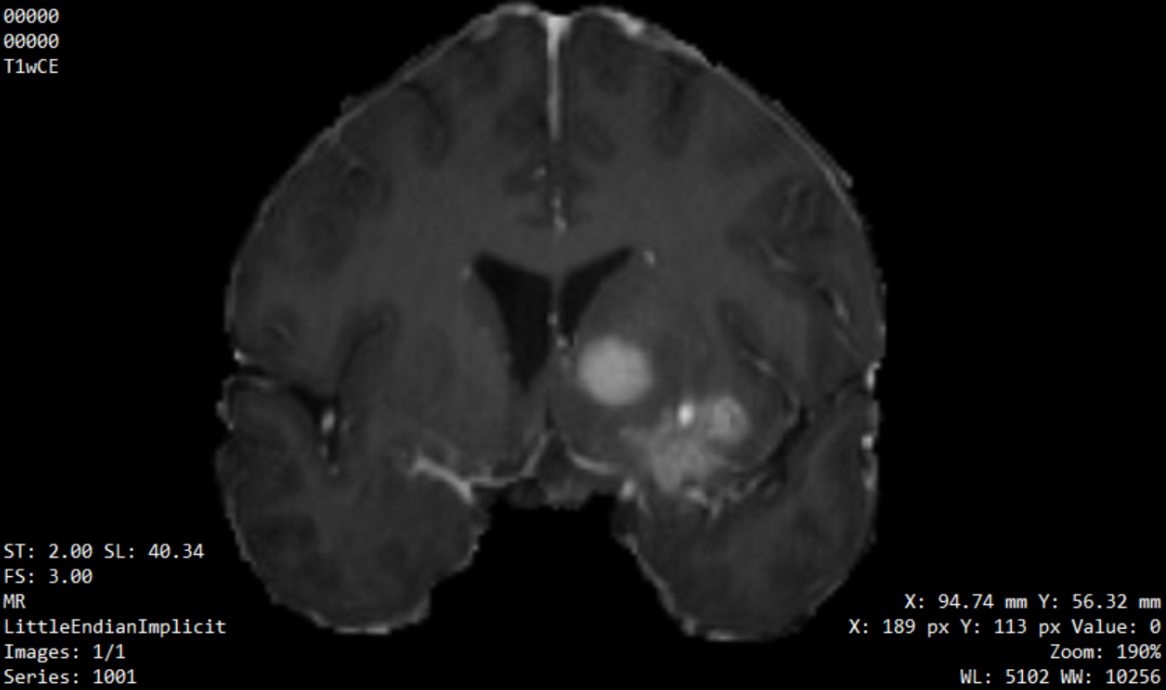

* References
1. k-NN method: https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83
2. RF and file handling: https://www.kaggle.com/alexisbcook/titanic-tutorial

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


In [ ]:
import pydicom
import random
import matplotlib.pyplot as plt
import glob


In [ ]:
# directory setting
INPUT = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'

In [ ]:
train_lab = pd.read_csv(INPUT + '/' + 'train_labels.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')


In [ ]:
print('Train labels')
train_lab

In [ ]:
temp = train_lab['BraTS21ID'] + 100000
item_id = []
for i in range(len(train_lab)):
    item_id = item_id + [str(temp[i])[-5:]]
print('Number of samples in training data')
len(item_id)   # 585

In [ ]:
def GenerateD(df, fol, Itype): # fol: 'train'; Itype: 'FLAIR'
    print('number, number of images, image_count, intensity, volume, average, Gmin, Gmax, Gmax-average, CmaxName')
    for i in range(len(item_id[:])):
        item_fol = os.listdir(INPUT + '/' + fol + '/' + item_id[i] + '/' + Itype)
        item_fol2 = []
        for j in item_fol:
            k = 1000 + int(j[6:len(j)-4])
            item_fol2 = item_fol2 + [k]
        item_fols = sorted(item_fol2)
        volume = 0
        intensity = 0
        image_count = 0
        vac = 0
        Gmax = 0
        Gmin = 0
        Amax = 0
        Imax = 0
        area_prev = 0
        sumN_prev = 0
        changeMax = 0
        maxName ='none'
        AmaxName ='none'
        ImaxName ='none'
        CmaxName ='00000'
        for j in item_fols:
            l = str(j-1000)
            path = INPUT + '/' + fol + '/' + item_id[i] + '/' + Itype + '/Image-' + l + '.dcm'
            dicom = pydicom.read_file(path)
            data = dicom.pixel_array
            sumN = np.sum(data)
            sumN_plus = sumN - sumN_prev
            sumN_prev = sumN
            if sumN > Imax:
                Imax = sumN
                ImaxName = j
            maxN = np.max(data)
            if maxN > Gmax:
                Gmax = maxN
                maxName = j
            minN = np.min(data)
            if minN < Gmin:
                Gmin = minN
            zerocount = np.count_nonzero(data == 0)
            area = np.count_nonzero(data != 0)
            if area >0:
                image_count = image_count +1
            area_plus = area - area_prev
            area_prev = area
            if area > Amax:
                Amax = area
                AmaxName = j
            change = -(sumN_plus/(area_plus+1))
            if change > changeMax:
                changeMax = change
                CmaxName = j
            intensity = intensity + sumN
            volume = volume + area
            vac = vac + zerocount
        average = intensity/(volume+1)
        df.loc[i,'c0'] = len(item_fol)
        df.loc[i,'c1'] = image_count
        df.loc[i,'c2'] = int(intensity)
        df.loc[i,'c3'] = volume
        df.loc[i,'c4'] = vac
        df.loc[i,'c5'] = volume+vac
        df.loc[i,'c6'] = average
        df.loc[i,'c7'] = Gmin
        df.loc[i,'c8'] = Gmax
        df.loc[i,'c9'] = Gmax-average
        df.loc[i,'c10'] = 'Image-' + str(int(CmaxName) -1000) + '.dcm'
        print(i, len(item_fol), image_count, intensity, volume, average, Gmin, Gmax, Gmax-average, 'Image-' + str(int(CmaxName) -1000) + '.dcm')
    return df

train_lab = GenerateD(train_lab, 'train', 'FLAIR') # fol: 'train'; Itype: 'FLAIR'

train_lab.head(10)

In [ ]:
fol_num = '00000'
fil_num = 70
pathA = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'+fol_num+'/FLAIR/Image-'+str(fil_num)+'.dcm'
dicom = pydicom.read_file(pathA)
data = dicom.pixel_array
# print(i+1, np.min(data), np.average(data), np.max(data), np.sum(data), np.max(data)/np.average(data))
print('An example image')
plt.figure(figsize=(16, 5))
plt.imshow(data, cmap="gray")
plt.show()

# for i in range(129):
#     fil_num = i+1
#     pathA = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'+fol_num+'/FLAIR/Image-'+str(fil_num)+'.dcm'
#     dicom = pydicom.read_file(pathA)
#     data = dicom.pixel_array
#     print(i+1, np.min(data), np.average(data), np.max(data), np.sum(data), np.max(data)/np.average(data))
#     plt.figure(figsize=(16, 5))
#     plt.imshow(data, cmap="gray")
#     plt.show()


In [ ]:
print(i, 'number of images', 'intensity', 'volume', 'average', 'Gmin', 'Gmax', 'Gmax-average', 'CmaxName')# for i in range(len(item_id[:10])):
# for i in range(len(item_id[:1])):
for i in range(len(item_id[:])):
    item_fol = os.listdir(INPUT + '/train/' + item_id[i] + '/FLAIR')
    item_fol2 = []
    for j in item_fol:
#         k = 'A' + j[6:len(j)-4]
        k = 1000 + int(j[6:len(j)-4])
        item_fol2 = item_fol2 + [k]
    item_fols = sorted(item_fol2)
#     volume = 0
#     intensity = 0
#     vac = 0
#     Gmax = 0
#     Gmin = 0
#     Amax = 0
#     Imax = 0
#     area_prev = 0
#     sumN_prev = 0
#     changeMax = 0
#     maxName ='none'
#     AmaxName ='none'
#     ImaxName ='none'
#     CmaxName ='00000'
    P50 = 0
    P60 = 0
    P70 = 0
    P80 = 0
    P90 = 0
    P95 = 0
    F2 = 0
    F3 = 0
    F4 = 0
    F5 = 0
    F6 = 0
    val50 = train_lab['c9'][i] * 0.5 + train_lab['c6'][i]
    val60 = train_lab['c9'][i] * 0.6 + train_lab['c6'][i]
    val70 = train_lab['c9'][i] * 0.7 + train_lab['c6'][i]
    val80 = train_lab['c9'][i] * 0.8 + train_lab['c6'][i]
    val90 = train_lab['c9'][i] * 0.9 + train_lab['c6'][i]
    val95 = train_lab['c9'][i] * 0.95 + train_lab['c6'][i]
    F2val = train_lab['c6'][i] * 2
    F3val = train_lab['c6'][i] * 3
    F4val = train_lab['c6'][i] * 4
    F5val = train_lab['c6'][i] * 5
    F6val = train_lab['c6'][i] * 6
    for j in item_fols:
        l = str(j-1000)
        path = INPUT + '/train/' + item_id[i] + '/FLAIR/Image-' + l + '.dcm'
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
#         sumN = np.sum(data)
#         sumN_plus = sumN - sumN_prev
#         sumN_prev = sumN
#         if sumN > Imax:
#             Imax = sumN
#             ImaxName = j
#         maxN = np.max(data)
#         if maxN > Gmax:
#             Gmax = maxN
#             maxName = j
#         minN = np.min(data)
#         if minN < Gmin:
#             Gmin = minN
        count50 = np.count_nonzero(data > val50)
        count60 = np.count_nonzero(data > val60)
        count70 = np.count_nonzero(data > val70)
        count80 = np.count_nonzero(data > val80)
        count90 = np.count_nonzero(data > val90)
        count95 = np.count_nonzero(data > val95)
        countF2 = np.count_nonzero(data > F2val)
        countF3 = np.count_nonzero(data > F3val)
        countF4 = np.count_nonzero(data > F4val)
        countF5 = np.count_nonzero(data > F5val)
        countF6 = np.count_nonzero(data > F6val)
#         area = np.count_nonzero(data != 0)
#         area_plus = area - area_prev
#         area_prev = area
#         if area > Amax:
#             Amax = area
#             AmaxName = j
#         change = -(sumN_plus/area_plus)
#         if change > changeMax:
#             changeMax = change
#             CmaxName = j
#         intensity = intensity + sumN
#         volume = volume + area
        P50 = P50 + count50
        P60 = P60 + count60
        P70 = P70 + count70
        P80 = P80 + count80
        P90 = P90 + count90
        P95 = P95 + count95
        F2 = F2 + countF2
        F3 = F3 + countF3
        F4 = F4 + countF4
        F5 = F5 + countF5
        F6 = F6 + countF6
#         print(i, j, sumN, maxN, minN, zerocount, area, area_plus, sumN_plus, change)
#     average = intensity/volume
#     train_lab.loc[i,'c1'] = len(item_fol)
#     train_lab.loc[i,'c2'] = int(intensity)
#     train_lab.loc[i,'c3'] = volume
#     train_lab.loc[i,'c4'] = vac
#     train_lab.loc[i,'c5'] = volume+vac
#     train_lab.loc[i,'c6'] = int(average)
#     train_lab.loc[i,'c7'] = Gmin
#     train_lab.loc[i,'c8'] = Gmax
#     train_lab.loc[i,'c9'] = int(Gmax-average)
#     train_lab.loc[i,'c10'] = 'Image-' + str(int(CmaxName) -1000) + '.dcm'
    c3val = train_lab['c3'][i]
    train_lab.loc[i,'c11'] = P50 * 1e7 / c3val
    train_lab.loc[i,'c12'] = P60 * 1e7 / c3val
    train_lab.loc[i,'c13'] = P70 * 1e7 / c3val
    train_lab.loc[i,'c14'] = P80 * 1e7 / c3val
    train_lab.loc[i,'c15'] = P90 * 1e7 / c3val
    train_lab.loc[i,'c16'] = P95 * 1e7 / c3val
    train_lab.loc[i,'c17'] = F2 *  1e7 / c3val
    train_lab.loc[i,'c18'] = F3 *  1e7 / c3val
    train_lab.loc[i,'c19'] = F4 * 1e7 / c3val
    train_lab.loc[i,'c20'] = F5 * 1e7 / c3val
    train_lab.loc[i,'c21'] = F6 * 1e7 / c3val
#     train_lab.loc[i,['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']] = (len(item_fol), intensity, volume, vac, volume+vac, average, Gmin, Gmax, int(Gmax-average))
#     train_lab.loc[i,['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']] = (len(item_fol), intensity, volume, vac, volume+vac, average, Gmin, Gmax, int(Gmax-average))
#     print(i, (P50, P60, P70, P80, P90, P95, 
#     print(i, (F2, F3, F4, F5, F6)*1e7/train_lab['c3'][i])

#     train_lab.c1[i] = len(item_fol)

# print(item_id[:1], maxName, AmaxName, ImaxName)
train_lab.head(10)

In [ ]:
train_lab

In [ ]:
train_lab.to_csv('Table_trainA.csv')
train_lab2 = train_lab[train_lab['c2'] != 0]
train_data = train_lab2.reset_index()
train_data

In [ ]:
def AddDif1(df):
    df2 = df
    df2['d1'] = df['c11'] - df['c12']
    df2['d2'] = df['c12'] - df['c13']
    df2['d3'] = df['c13'] - df['c14']
    df2['d4'] = df['c14'] - df['c15']
    df2['d5'] = df['c15'] - df['c16']
    return df2
    
train_data = AddDif1(train_data)
train_data

In [ ]:
sample_sub

In [ ]:
temp = sample_sub['BraTS21ID'] + 100000
item_id = []
for i in range(len(sample_sub)):
    item_id = item_id + [str(temp[i])[-5:]]
print('Number of samples in test data')
len(item_id)   # 87

In [ ]:
train_lab = sample_sub

# Note: change 'train' path to 'test'

In [ ]:
train_lab = GenerateD(train_lab, 'test', 'FLAIR') # fol: 'train'; Itype: 'FLAIR'

train_lab.head(10)

In [ ]:
print(i, 'number of images', 'intensity', 'volume', 'average', 'Gmin', 'Gmax', 'Gmax-average', 'CmaxName')# for i in range(len(item_id[:10])):
# for i in range(len(item_id[:1])):
for i in range(len(item_id[:])):
    item_fol = os.listdir(INPUT + '/test/' + item_id[i] + '/FLAIR')
    item_fol2 = []
    for j in item_fol:
#         k = 'A' + j[6:len(j)-4]
        k = 1000 + int(j[6:len(j)-4])
        item_fol2 = item_fol2 + [k]
    item_fols = sorted(item_fol2)
#     volume = 0
#     intensity = 0
#     vac = 0
#     Gmax = 0
#     Gmin = 0
#     Amax = 0
#     Imax = 0
#     area_prev = 0
#     sumN_prev = 0
#     changeMax = 0
#     maxName ='none'
#     AmaxName ='none'
#     ImaxName ='none'
#     CmaxName ='00000'
    P50 = 0
    P60 = 0
    P70 = 0
    P80 = 0
    P90 = 0
    P95 = 0
    F2 = 0
    F3 = 0
    F4 = 0
    F5 = 0
    F6 = 0
    val50 = train_lab['c9'][i] * 0.5 + train_lab['c6'][i]
    val60 = train_lab['c9'][i] * 0.6 + train_lab['c6'][i]
    val70 = train_lab['c9'][i] * 0.7 + train_lab['c6'][i]
    val80 = train_lab['c9'][i] * 0.8 + train_lab['c6'][i]
    val90 = train_lab['c9'][i] * 0.9 + train_lab['c6'][i]
    val95 = train_lab['c9'][i] * 0.95 + train_lab['c6'][i]
    F2val = train_lab['c6'][i] * 2
    F3val = train_lab['c6'][i] * 3
    F4val = train_lab['c6'][i] * 4
    F5val = train_lab['c6'][i] * 5
    F6val = train_lab['c6'][i] * 6
    for j in item_fols:
        l = str(j-1000)
        path = INPUT + '/test/' + item_id[i] + '/FLAIR/Image-' + l + '.dcm'
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
#         sumN = np.sum(data)
#         sumN_plus = sumN - sumN_prev
#         sumN_prev = sumN
#         if sumN > Imax:
#             Imax = sumN
#             ImaxName = j
#         maxN = np.max(data)
#         if maxN > Gmax:
#             Gmax = maxN
#             maxName = j
#         minN = np.min(data)
#         if minN < Gmin:
#             Gmin = minN
        count50 = np.count_nonzero(data > val50)
        count60 = np.count_nonzero(data > val60)
        count70 = np.count_nonzero(data > val70)
        count80 = np.count_nonzero(data > val80)
        count90 = np.count_nonzero(data > val90)
        count95 = np.count_nonzero(data > val95)
        countF2 = np.count_nonzero(data > F2val)
        countF3 = np.count_nonzero(data > F3val)
        countF4 = np.count_nonzero(data > F4val)
        countF5 = np.count_nonzero(data > F5val)
        countF6 = np.count_nonzero(data > F6val)
#         area = np.count_nonzero(data != 0)
#         area_plus = area - area_prev
#         area_prev = area
#         if area > Amax:
#             Amax = area
#             AmaxName = j
#         change = -(sumN_plus/area_plus)
#         if change > changeMax:
#             changeMax = change
#             CmaxName = j
#         intensity = intensity + sumN
#         volume = volume + area
        P50 = P50 + count50
        P60 = P60 + count60
        P70 = P70 + count70
        P80 = P80 + count80
        P90 = P90 + count90
        P95 = P95 + count95
        F2 = F2 + countF2
        F3 = F3 + countF3
        F4 = F4 + countF4
        F5 = F5 + countF5
        F6 = F6 + countF6
#         print(i, j, sumN, maxN, minN, zerocount, area, area_plus, sumN_plus, change)
#     average = intensity/volume
#     train_lab.loc[i,'c1'] = len(item_fol)
#     train_lab.loc[i,'c2'] = int(intensity)
#     train_lab.loc[i,'c3'] = volume
#     train_lab.loc[i,'c4'] = vac
#     train_lab.loc[i,'c5'] = volume+vac
#     train_lab.loc[i,'c6'] = int(average)
#     train_lab.loc[i,'c7'] = Gmin
#     train_lab.loc[i,'c8'] = Gmax
#     train_lab.loc[i,'c9'] = int(Gmax-average)
#     train_lab.loc[i,'c10'] = 'Image-' + str(int(CmaxName) -1000) + '.dcm'
    c3val = train_lab['c3'][i]
    train_lab.loc[i,'c11'] = P50 * 1e7 / c3val
    train_lab.loc[i,'c12'] = P60 * 1e7 / c3val
    train_lab.loc[i,'c13'] = P70 * 1e7 / c3val
    train_lab.loc[i,'c14'] = P80 * 1e7 / c3val
    train_lab.loc[i,'c15'] = P90 * 1e7 / c3val
    train_lab.loc[i,'c16'] = P95 * 1e7 / c3val
    train_lab.loc[i,'c17'] = F2 *  1e7 / c3val
    train_lab.loc[i,'c18'] = F3 *  1e7 / c3val
    train_lab.loc[i,'c19'] = F4 * 1e7 / c3val
    train_lab.loc[i,'c20'] = F5 * 1e7 / c3val
    train_lab.loc[i,'c21'] = F6 * 1e7 / c3val
#     train_lab.loc[i,['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']] = (len(item_fol), intensity, volume, vac, volume+vac, average, Gmin, Gmax, int(Gmax-average))
#     train_lab.loc[i,['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']] = (len(item_fol), intensity, volume, vac, volume+vac, average, Gmin, Gmax, int(Gmax-average))
#     print(i, (P50, P60, P70, P80, P90, P95, 
#     print(i, (F2, F3, F4, F5, F6)*1e7/train_lab['c3'][i])

#     train_lab.c1[i] = len(item_fol)

# print(item_id[:1], maxName, AmaxName, ImaxName)
train_lab.head(10)

In [ ]:
sample_sub = train_lab     # <=== Caution!

In [ ]:
sample_sub.to_csv('Table_testA.csv')
test_data = sample_sub
test_data

In [ ]:
test_data = AddDif1(test_data)
test_data

In [ ]:
output = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
output

# k-Nearest neighbor or Random forest

In [ ]:
features = ["c2", "c3", "c4", "c5", "c6", "c8", "c9", 
#             "c11", "c12", "c13", "c14", "c15", "c16",
            "d1", "d2", "d3", "d4", "d5"]
y = train_data["MGMT_value"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

In [ ]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [ ]:
# # KNN
# n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22,24,26]
# algorithm = ['auto']
# weights = ['uniform', 'distance']
# leaf_size = list(range(1,50,5))
# hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
#                'n_neighbors': n_neighbors}
# gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
#                 cv=9, scoring = "roc_auc")
# gd.fit(X, y)
# print(gd.best_score_)
# print(gd.best_estimator_)

# gd.best_estimator_.fit(X, y)
# y_pred = gd.best_estimator_.predict_proba(X_test)[:,1]
# y_pred

# y_score1 = gd.best_estimator_.predict_proba(X)[:,1]
# predictions = gd.best_estimator_.predict_proba(X_test)[:,1]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["MGMT_value"]

features = ["c2", "c3", "c4", "c5", "c6", "c8", "c9", 
#             "c11", "c12", "c13", "c14", "c15", "c16",
            "d1", "d2", "d3", "d4", "d5"]
#             "c17", "c18", "c19", "c20", "c21"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=1)
model.fit(X, y)

y_score1 = model.predict_proba(X)[:,1]
predictions = model.predict_proba(X_test)[:,1]


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_true1 = y
# # y_score1 = model.predict_proba(X)[:,1]
# y_score1 = gd.best_estimator_.predict_proba(X)[:,1]

roc1 = roc_curve(y_true1, y_score1)

fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_score1)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
y_pred = np.round(y_score1, decimals = 0)
tn1, fp1, fn1, tp1 = confusion_matrix(y_true1, y_pred).ravel()
ac1 = accuracy_score(y_true1, y_pred)
pr1 = precision_score(y_true1, y_pred)
rc1 = recall_score(y_true1, y_pred)
sp1 = tn1/(fp1+tn1)
f11 = f1_score(y_true1, y_pred)
phi1 = (tp1*tn1-fp1*fn1)/np.sqrt((tp1+fn1)*(tp1+fp1)*(tn1+fn1)*(tn1+fp1))

# y_true2 = y_vali
# y_score2 = p_vali

# roc2 = roc_curve(y_true2, y_score2)

# fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_score2)
# y_pred = np.round(p_vali, decimals = 0)
# tn2, fp2, fn2, tp2 = confusion_matrix(y_true2, y_pred).ravel()
# ac2 = accuracy_score(y_true2, y_pred)
# pr2 = precision_score(y_true2, y_pred)
# rc2 = recall_score(y_true2, y_pred)
# sp2 = tn2/(fp2+tn2)
# f12 = f1_score(y_true2, y_pred)
# phi2 = (tp2*tn2-fp2*fn2)/np.sqrt((tp2+fn2)*(tp2+fp2)*(tn2+fn2)*(tn2+fp2))

# y_true3 = y_test
# y_score3 = p_test

# roc3 = roc_curve(y_true3, y_score3)

# fpr3, tpr3, thresholds3 = roc_curve(y_true3, y_score3)
# y_pred = np.round(p_test, decimals = 0)
# tn3, fp3, fn3, tp3 = confusion_matrix(y_true3, y_pred).ravel()
# ac3 = accuracy_score(y_true3, y_pred)
# pr3 = precision_score(y_true3, y_pred)
# rc3 = recall_score(y_true3, y_pred)
# sp3 = tn3/(fp3+tn3)
# f13 = f1_score(y_true3, y_pred)
# phi3 = (tp3*tn3-fp3*fn3)/np.sqrt((tp3+fn3)*(tp3+fp3)*(tn3+fn3)*(tn3+fp3))

plt.figure(figsize=(6,6))
plt.plot((0,1), (0,1), color="black", linestyle="--")
plt.plot(fpr1, tpr1, linewidth=3)#, marker='o')
# plt.plot(fpr2, tpr2, linewidth=3)#, marker='o')
# plt.plot(fpr3, tpr3, linewidth=3)#, marker='o')
plt.tick_params(direction='in')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
# plt.legend(['train', 'valid', 'test'], loc='lower right')
plt.grid()
ROC1=roc_auc_score(y_true1, y_score1)
# ROC2=roc_auc_score(y_true2, y_score2)
# ROC3=roc_auc_score(y_true3, y_score3)
print(ROC1)#,ROC2,ROC3)

In [ ]:
# for i in range(len(X)):
#     print(i, y[i], model.predict_proba(X)[:,1][i])

In [ ]:
# predictions = model.predict_proba(X_test)[:,1]
# predictions = gd.best_estimator_.predict_proba(X_test)[:,1]
output['MGMT_value'] = predictions
output

In [ ]:
temp = output['BraTS21ID'] + 100000
item_id = []
for i in range(len(temp)):
    item_id = item_id + [str(temp[i])[-5:]]
output['BraTS21ID'] = item_id

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
output

In [ ]:
feature_importance = model.feature_importances_
print('Feature importances')
for i in range(len(features)):
    print(features[i], feature_importance[i])

In [ ]:
import matplotlib.pyplot as plt
indices = np.argsort(feature_importance)[::1]
plt.figure(figsize = (6, 6))
plt.barh(np.array(features)[indices], feature_importance[indices], height = 0.5)
plt.yticks(fontsize = 20)
plt.xlabel("Feature importances", fontsize = 25)
plt.show()

In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Resulting_train = pd.read_csv('../input/rf-brain-tumor-flair/Table_trainA.csv')
# # len(Resulting_train)

# def AddDif1(df):
#     df2 = df
#     df2['d1'] = df['c11'] - df['c12']
#     df2['d2'] = df['c12'] - df['c13']
#     df2['d3'] = df['c13'] - df['c14']
#     df2['d4'] = df['c14'] - df['c15']
#     df2['d5'] = df['c15'] - df['c16']
#     return df2
    
# Resulting_train = AddDif1(Resulting_train)
Resulting_train = train_data
Resulting_train.head(2)

In [ ]:
Positive_train = Resulting_train[Resulting_train.MGMT_value == 1]
Negative_train = Resulting_train[Resulting_train.MGMT_value == 0]
(len(Positive_train), len(Negative_train), len(Positive_train) + len(Negative_train))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, ax = plt.subplots(4, 3, figsize=(12, 9))
sns.set_palette(sns.color_palette("icefire"))

sns.kdeplot(data=Positive_train['c2'], label="positive", color="#9999ff", shade=True, ax=ax[0][0])
sns.kdeplot(data=Negative_train['c2'], label="negative", color="#ffaaaa", shade=True, ax=ax[0][0])
ax[0][0].set_title('c2', fontsize=15, fontweight='bold')
ax[0][0].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c3'], label="positive", color="#9999ff", shade=True, ax=ax[0][1])
sns.kdeplot(data=Negative_train['c3'], label="negative", color="#ffaaaa", shade=True, ax=ax[0][1])
ax[0][1].set_title('c3', fontsize=15, fontweight='bold')
ax[0][1].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c4'], label="positive", color="#9999ff", shade=True, ax=ax[0][2])
sns.kdeplot(data=Negative_train['c4'], label="negative", color="#ffaaaa", shade=True, ax=ax[0][2])
ax[0][2].set_title('c4', fontsize=15, fontweight='bold')
ax[0][2].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c6'], label="positive", color="#9999ff", shade=True, ax=ax[1][0])
sns.kdeplot(data=Negative_train['c6'], label="negative", color="#ffaaaa", shade=True, ax=ax[1][0])
ax[1][0].set_title('c6', fontsize=15, fontweight='bold')
ax[1][0].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c8'], label="positive", color="#9999ff", shade=True, ax=ax[1][1])
sns.kdeplot(data=Negative_train['c8'], label="negative", color="#ffaaaa", shade=True, ax=ax[1][1])
ax[1][1].set_title('c8', fontsize=15, fontweight='bold')
ax[1][1].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c9'], label="positive", color="#9999ff", shade=True, ax=ax[1][2])
sns.kdeplot(data=Negative_train['c9'], label="negative", color="#ffaaaa", shade=True, ax=ax[1][2])
ax[1][2].set_title('c9', fontsize=15, fontweight='bold')
ax[1][2].tick_params(direction='in')

sns.kdeplot(data=Positive_train['d1'], label="positive", color="#9999ff", shade=True, ax=ax[2][0])
sns.kdeplot(data=Negative_train['d1'], label="negative", color="#ffaaaa", shade=True, ax=ax[2][0])
ax[2][0].set_title('d1', fontsize=15, fontweight='bold')
ax[2][0].tick_params(direction='in')

sns.kdeplot(data=Positive_train['d2'], label="positive", color="#9999ff", shade=True, ax=ax[2][1])
sns.kdeplot(data=Negative_train['d2'], label="negative", color="#ffaaaa", shade=True, ax=ax[2][1])
ax[2][1].set_title('d2', fontsize=15, fontweight='bold')
ax[2][1].tick_params(direction='in')

sns.kdeplot(data=Positive_train['d3'], label="positive", color="#9999ff", shade=True, ax=ax[2][2])
sns.kdeplot(data=Negative_train['d3'], label="negative", color="#ffaaaa", shade=True, ax=ax[2][2])
ax[2][2].set_title('d3', fontsize=15, fontweight='bold')
ax[2][2].tick_params(direction='in')

sns.kdeplot(data=Positive_train['d4'], label="positive", color="#9999ff", shade=True, ax=ax[3][0])
sns.kdeplot(data=Negative_train['d4'], label="negative", color="#ffaaaa", shade=True, ax=ax[3][0])
ax[3][0].set_title('d4', fontsize=15, fontweight='bold')
ax[3][0].tick_params(direction='in')

sns.kdeplot(data=Positive_train['d5'], label="positive", color="#9999ff", shade=True, ax=ax[3][1])
sns.kdeplot(data=Negative_train['d5'], label="negative", color="#ffaaaa", shade=True, ax=ax[3][1])
ax[3][1].set_title('d4', fontsize=15, fontweight='bold')
ax[3][1].tick_params(direction='in')

sns.kdeplot(data=Positive_train['c1'], label="positive", color="#9999ff", shade=True, ax=ax[3][2])
sns.kdeplot(data=Negative_train['c1'], label="negative", color="#ffaaaa", shade=True, ax=ax[3][2])
ax[3][2].set_title('c1', fontsize=15, fontweight='bold')
ax[3][2].tick_params(direction='in')


fig.suptitle('Distribution: positive (blue) and nagative (red)', fontsize=20, fontweight='bold')

fig.tight_layout(rect=[0, 0.03, 1, 0.90]);

In [ ]:
Debug_mode = False

In [ ]:
# directory setting
INPUT = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
train_lab = pd.read_csv(INPUT + '/' + 'train_labels.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

if Debug_mode == True:
    train_lab = train_lab.iloc[:5,:] ###########################################
    
temp = train_lab['BraTS21ID'] + 100000
item_id = []
for i in range(len(train_lab)):
    item_id = item_id + [str(temp[i])[-5:]]


In [ ]:
'''
各画像の平均値と標準偏差を取得し、まとめる
'''
def GenerateH(df, fol, Itype): # fol: 'train'; Itype: 'FLAIR'
    Types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
#     print('Start 1')
    for i in range(len(item_id[:])):
        item_fol = os.listdir(INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype])
        item_fol2 = []
        for j in item_fol:
            k = 1000 + int(j[6:len(j)-4])
            item_fol2 = item_fol2 + [k]
        item_fols = sorted(item_fol2)

        heikin = []
        hensa = []
        saidai = []
        for j in item_fols:
            l = str(j-1000)
            path = INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype] + '/Image-' + l + '.dcm'
            dicom = pydicom.read_file(path)
            data = dicom.pixel_array
            dataF = data.flatten()
            dataB = np.setdiff1d(dataF, [0])
            if len(dataB) > 0:
                heikin = heikin + [np.nanmean(dataB)]
                hensa = hensa + [np.nanstd(dataB, ddof=1)]
                saidai = saidai + [np.nanmax(dataB)]
#         print(i, np.mean(heikin), np.std(heikin, ddof=1), np.mean(hensa), np.std(hensa, ddof=1))           
#         print(i, np.mean(saidai), np.std(saidai, ddof=1))           
            
        df.loc[i, str(Itype)+'h1'] = np.nanmean(heikin)
        df.loc[i, str(Itype)+'h2'] = np.nanstd(heikin, ddof=1)
        df.loc[i, str(Itype)+'h3'] = np.nanmean(hensa)
        df.loc[i, str(Itype)+'h4'] = np.nanstd(hensa, ddof=1)
        df.loc[i, str(Itype)+'h5'] = np.nanmean(saidai)
        df.loc[i, str(Itype)+'h6'] = np.nanstd(saidai, ddof=1)
    return df

def GenerateD(df, fol, Itype): # fol: 'train'; Itype: 'FLAIR'
    Types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
#     print('Start 1')
    for i in range(len(item_id[:])):
        item_fol = os.listdir(INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype])
        item_fol2 = []
        for j in item_fol:
            k = 1000 + int(j[6:len(j)-4])
            item_fol2 = item_fol2 + [k]
        item_fols = sorted(item_fol2)
        volume = 0
        intensity = 0
        image_count = 0
        vac = 0
        Gmax = 0
        Gmin = 0
#         Amax = 0
#         Imax = 0
#         area_prev = 0
#         sumN_prev = 0
#         changeMax = 0
#         maxName ='none'
#         AmaxName ='none'
#         ImaxName ='none'
#         CmaxName ='00000'
        for j in item_fols:
            l = str(j-1000)
            path = INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype] + '/Image-' + l + '.dcm'
            dicom = pydicom.read_file(path)
            data = dicom.pixel_array
            sumN = np.sum(data)
#             sumN_plus = sumN - sumN_prev
#             sumN_prev = sumN
#             if sumN > Imax:
#                 Imax = sumN
#                 ImaxName = j
            maxN = np.max(data)
            if maxN > Gmax:
                Gmax = maxN
#                 maxName = j
            minN = np.min(data)
            if minN < Gmin:
                Gmin = minN
            zerocount = np.count_nonzero(data == 0)
            area = np.count_nonzero(data != 0)
            if area >0:
                image_count = image_count +1
#             area_plus = area - area_prev
#             area_prev = area
#             if area > Amax:
#                 Amax = area
#                 AmaxName = j
#             change = -(sumN_plus/(area_plus+1))
#             if change > changeMax:
#                 changeMax = change
#                 CmaxName = j
            intensity = intensity + sumN
            volume = volume + area
            vac = vac + zerocount
        average = intensity/(volume+1)
        df.loc[i, str(Itype)+'c0'] = len(item_fol)
        df.loc[i, str(Itype)+'c1'] = image_count
        df.loc[i, str(Itype)+'c2'] = intensity
        df.loc[i, str(Itype)+'c3'] = volume
        df.loc[i, str(Itype)+'c4'] = vac
        df.loc[i, str(Itype)+'c5'] = volume+vac
        df.loc[i, str(Itype)+'c6'] = average
        df.loc[i, str(Itype)+'c7'] = Gmin
        df.loc[i, str(Itype)+'c8'] = Gmax
        df.loc[i, str(Itype)+'c9'] = Gmax-average
#         df.loc[i,'c10'] = 'Image-' + str(int(CmaxName) -1000) + '.dcm'
#         print(i, len(item_fol), image_count, intensity, volume, average, Gmin, Gmax, Gmax-average)#, 'Image-' + str(int(CmaxName) -1000) + '.dcm')
    return df

def GenerateD2(df, fol, Itype): # fol: 'train'; Itype: 'FLAIR'
    Types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    for i in range(len(item_id[:])):
        item_fol = os.listdir(INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype])
        item_fol2 = []
        for j in item_fol:
            k = 1000 + int(j[6:len(j)-4])
            item_fol2 = item_fol2 + [k]
        item_fols = sorted(item_fol2)
        Gmean = df[str(Itype)+'c6'][i] # Gmean
        B10 = Gmean * 0.2
        B20 = Gmean * 0.4
        B30 = Gmean * 0.6
        B40 = Gmean * 0.8
        B50 = Gmean
        B60 = Gmean * 1.2
        B70 = Gmean * 1.4
        B80 = Gmean * 1.6
        B90 = Gmean * 1.8
        B100 = Gmean * 2
        B110 = Gmean * 2.2
        B120 = Gmean * 2.4
        B130 = Gmean * 2.6
        B140 = Gmean * 2.8
        B150 = Gmean * 3
        B160 = Gmean * 3.2
        B170 = Gmean * 3.4
        B180 = Gmean * 3.6
        B190 = Gmean * 3.8
        B200 = Gmean * 4
        B210 = Gmean * 4.2
        B220 = Gmean * 4.4
        B230 = Gmean * 4.6
        B240 = Gmean * 4.8
        B250 = Gmean * 5
        B260 = Gmean * 5.2
        B270 = Gmean * 5.4
        B280 = Gmean * 5.6
        B290 = Gmean * 5.8
        B300 = Gmean * 6
        
        count10 = 0
        count20 = 0
        count30 = 0
        count40 = 0
        count50 = 0
        count60 = 0
        count70 = 0
        count80 = 0
        count90 = 0
        count100 = 0
        count110 = 0
        count120 = 0
        count130 = 0
        count140 = 0
        count150 = 0
        count160 = 0
        count170 = 0
        count180 = 0
        count190 = 0
        count200 = 0
        count210 = 0
        count220 = 0
        count230 = 0
        count240 = 0
        count250 = 0
        count260 = 0
        count270 = 0
        count280 = 0
        count290 = 0
        count300 = 0
        
        for j in item_fols:
            l = str(j-1000)
            path = INPUT + '/' + fol + '/' + item_id[i] + '/' + Types[Itype] + '/Image-' + l + '.dcm'
            dicom = pydicom.read_file(path)
            data = dicom.pixel_array
            cou10 = np.count_nonzero(data < B10)
            cou20 = np.count_nonzero(data < B20)
            cou30 = np.count_nonzero(data < B30)
            cou40 = np.count_nonzero(data < B40)
            cou50 = np.count_nonzero(data < B50)
            cou60 = np.count_nonzero(data < B60)
            cou70 = np.count_nonzero(data < B70)
            cou80 = np.count_nonzero(data < B80)
            cou90 = np.count_nonzero(data < B90)
            cou100 = np.count_nonzero(data < B100)
            cou110 = np.count_nonzero(data < B110)
            cou120 = np.count_nonzero(data < B120)
            cou130 = np.count_nonzero(data < B130)
            cou140 = np.count_nonzero(data < B140)
            cou150 = np.count_nonzero(data < B150)
            cou160 = np.count_nonzero(data < B160)
            cou170 = np.count_nonzero(data < B170)
            cou180 = np.count_nonzero(data < B180)
            cou190 = np.count_nonzero(data < B190)
            cou200 = np.count_nonzero(data < B200)
            cou210 = np.count_nonzero(data < B210)
            cou220 = np.count_nonzero(data < B220)
            cou230 = np.count_nonzero(data < B230)
            cou240 = np.count_nonzero(data < B240)
            cou250 = np.count_nonzero(data < B250)
            cou260 = np.count_nonzero(data < B260)
            cou270 = np.count_nonzero(data < B270)
            cou280 = np.count_nonzero(data < B280)
            cou290 = np.count_nonzero(data < B290)
            cou300 = np.count_nonzero(data < B300)

            count10 = count10 + cou10
            count20 = count20 + cou20
            count30 = count30 + cou30
            count40 = count40 + cou40
            count50 = count50 + cou50
            count60 = count60 + cou60
            count70 = count70 + cou70
            count80 = count80 + cou80
            count90 = count90 + cou90
            count100 = count100 + cou100
            count110 = count110 + cou110
            count120 = count120 + cou120
            count130 = count130 + cou130
            count140 = count140 + cou140
            count150 = count150 + cou150
            count160 = count160 + cou160
            count170 = count170 + cou170
            count180 = count180 + cou180
            count190 = count190 + cou190
            count200 = count200 + cou200
            count210 = count210 + cou210
            count220 = count220 + cou220
            count230 = count230 + cou230
            count240 = count240 + cou240
            count250 = count250 + cou250
            count260 = count260 + cou260
            count270 = count270 + cou270
            count280 = count280 + cou280
            count290 = count290 + cou290
            count300 = count300 + cou300

        Volume1 = (df[str(Itype)+'c3'][i] + 1) / 100
        vac = df[str(Itype)+'c4'][i]

        df.loc[i, str(Itype)+'B1'] = (count10 - vac) / Volume1
        df.loc[i, str(Itype)+'B2'] = (count20 - vac) / Volume1
        df.loc[i, str(Itype)+'B3'] = (count30 - vac) / Volume1
        df.loc[i, str(Itype)+'B4'] = (count40 - vac) / Volume1
        df.loc[i, str(Itype)+'B5'] = (count50 - vac) / Volume1
        df.loc[i, str(Itype)+'B6'] = (count60 - vac) / Volume1
        df.loc[i, str(Itype)+'B7'] = (count70 - vac) / Volume1
        df.loc[i, str(Itype)+'B8'] = (count80 - vac) / Volume1
        df.loc[i, str(Itype)+'B9'] = (count90 - vac) / Volume1
        df.loc[i, str(Itype)+'B10'] = (count100 - vac) / Volume1
        df.loc[i, str(Itype)+'B11'] = (count110 - vac) / Volume1
        df.loc[i, str(Itype)+'B12'] = (count120 - vac) / Volume1
        df.loc[i, str(Itype)+'B13'] = (count130 - vac) / Volume1
        df.loc[i, str(Itype)+'B14'] = (count140 - vac) / Volume1
        df.loc[i, str(Itype)+'B15'] = (count150 - vac) / Volume1
        df.loc[i, str(Itype)+'B16'] = (count160 - vac) / Volume1
        df.loc[i, str(Itype)+'B17'] = (count170 - vac) / Volume1
        df.loc[i, str(Itype)+'B18'] = (count180 - vac) / Volume1
        df.loc[i, str(Itype)+'B19'] = (count190 - vac) / Volume1
        df.loc[i, str(Itype)+'B20'] = (count200 - vac) / Volume1
        df.loc[i, str(Itype)+'B21'] = (count210 - vac) / Volume1
        df.loc[i, str(Itype)+'B22'] = (count220 - vac) / Volume1
        df.loc[i, str(Itype)+'B23'] = (count230 - vac) / Volume1
        df.loc[i, str(Itype)+'B24'] = (count240 - vac) / Volume1
        df.loc[i, str(Itype)+'B25'] = (count250 - vac) / Volume1
        df.loc[i, str(Itype)+'B26'] = (count260 - vac) / Volume1
        df.loc[i, str(Itype)+'B27'] = (count270 - vac) / Volume1
        df.loc[i, str(Itype)+'B28'] = (count280 - vac) / Volume1
        df.loc[i, str(Itype)+'B29'] = (count290 - vac) / Volume1
        df.loc[i, str(Itype)+'B30'] = (count300 - vac) / Volume1

        
        
#         df.loc[i,'c12'] = P60 * 1e7 / c3val
#         df.loc[i,'c13'] = P70 * 1e7 / c3val
#         df.loc[i,'c14'] = P80 * 1e7 / c3val
#         df.loc[i,'c15'] = P90 * 1e7 / c3val
#         df.loc[i,'c16'] = P95 * 1e7 / c3val
#         df.loc[i,'b1'] = (B10 - c4val) * 1e7 / c3val
#         df.loc[i,'b2'] = (B20 - c4val) * 1e7 / c3val
#         df.loc[i,'b3'] = (B30 - c4val) * 1e7 / c3val
#         df.loc[i,'b4'] = (B40 - c4val) * 1e7 / c3val
#         df.loc[i,'b5'] = (B50 - c4val) * 1e7 / c3val
#         df.loc[i,'c17'] = F2 *  1e7 / c3val
#         df.loc[i,'c18'] = F3 *  1e7 / c3val
#         df.loc[i,'c19'] = F4 * 1e7 / c3val
#         df.loc[i,'c20'] = F5 * 1e7 / c3val
#         df.loc[i,'c21'] = F6 * 1e7 / c3val
    return df

def AddDif1(df):
    df2 = df
    for i in range(4):
        df2[str(i)+'d1'] = df[str(i)+'B1']
        df2[str(i)+'d2'] = df[str(i)+'B2'] - df[str(i)+'B1']
        df2[str(i)+'d3'] = df[str(i)+'B3'] - df[str(i)+'B2']
        df2[str(i)+'d4'] = df[str(i)+'B4'] - df[str(i)+'B3']
        df2[str(i)+'d5'] = df[str(i)+'B5'] - df[str(i)+'B4']
        df2[str(i)+'d6'] = df[str(i)+'B6'] - df[str(i)+'B5']
        df2[str(i)+'d7'] = df[str(i)+'B7'] - df[str(i)+'B6']
        df2[str(i)+'d8'] = df[str(i)+'B8'] - df[str(i)+'B7']
        df2[str(i)+'d9'] = df[str(i)+'B9'] - df[str(i)+'B8']
        df2[str(i)+'d10'] = df[str(i)+'B10'] - df[str(i)+'B9']
        df2[str(i)+'d11'] = df[str(i)+'B11'] - df[str(i)+'B10']
        df2[str(i)+'d12'] = df[str(i)+'B12'] - df[str(i)+'B11']
        df2[str(i)+'d13'] = df[str(i)+'B13'] - df[str(i)+'B12']
        df2[str(i)+'d14'] = df[str(i)+'B14'] - df[str(i)+'B13']
        df2[str(i)+'d15'] = df[str(i)+'B15'] - df[str(i)+'B14']
        df2[str(i)+'d16'] = df[str(i)+'B16'] - df[str(i)+'B15']
        df2[str(i)+'d17'] = df[str(i)+'B17'] - df[str(i)+'B16']
        df2[str(i)+'d18'] = df[str(i)+'B18'] - df[str(i)+'B17']
        df2[str(i)+'d19'] = df[str(i)+'B19'] - df[str(i)+'B18']
        df2[str(i)+'d20'] = df[str(i)+'B20'] - df[str(i)+'B19']
        df2[str(i)+'d21'] = df[str(i)+'B21'] - df[str(i)+'B20']
        df2[str(i)+'d22'] = df[str(i)+'B22'] - df[str(i)+'B21']
        df2[str(i)+'d23'] = df[str(i)+'B23'] - df[str(i)+'B22']
        df2[str(i)+'d24'] = df[str(i)+'B24'] - df[str(i)+'B23']
        df2[str(i)+'d25'] = df[str(i)+'B25'] - df[str(i)+'B24']
        df2[str(i)+'d26'] = df[str(i)+'B26'] - df[str(i)+'B25']
        df2[str(i)+'d27'] = df[str(i)+'B27'] - df[str(i)+'B26']
        df2[str(i)+'d28'] = df[str(i)+'B28'] - df[str(i)+'B27']
        df2[str(i)+'d29'] = df[str(i)+'B29'] - df[str(i)+'B28']
        df2[str(i)+'d30'] = df[str(i)+'B30'] - df[str(i)+'B29']
        df2[str(i)+'d31'] = df[str(i)+'c3']/((df[str(i)+'c3']+1)/100) - df[str(i)+'B30']
        df2[str(i)+'d32'] = df[str(i)+'d1'] + df[str(i)+'d2'] + df[str(i)+'d3'] + df[str(i)+'d4'] + df[str(i)+'d5'] + df[str(i)+'d6'] + df[str(i)+'d7'] + df[str(i)+'d8'] + df[str(i)+'d9'] + df[str(i)+'d10'] + df[str(i)+'d11'] + df[str(i)+'d12'] + df[str(i)+'d13'] + df[str(i)+'d14'] + df[str(i)+'d15'] + df[str(i)+'d16'] + df[str(i)+'d17'] + df[str(i)+'d18'] + df[str(i)+'d19'] + df[str(i)+'d20'] + df[str(i)+'d21'] + df[str(i)+'d22'] + df[str(i)+'d23'] + df[str(i)+'d24'] + df[str(i)+'d25'] + df[str(i)+'d26'] + df[str(i)+'d27'] + df[str(i)+'d28'] + df[str(i)+'d29'] + df[str(i)+'d30'] + df[str(i)+'d31']

    return df2


In [ ]:
for i in range(4):
    train_lab = GenerateH(train_lab, 'train', i) # fol: 'train'; Itype: 'FLAIR', 'T1w', 'T2w', 'T2w'

for i in range(4):
    train_lab = GenerateD(train_lab, 'train', i) # fol: 'train'; Itype: 'FLAIR', 'T1w', 'T2w', 'T2w'

for i in range(4):
    train_lab = GenerateD2(train_lab, 'train', i) # fol: 'train'; Itype: 'FLAIR'

train_lab.to_csv('Table_trainAx.csv', index=False)
train_lab2 = train_lab[train_lab['0c2'] != 0]
train_lab2 = train_lab2[train_lab['1c2'] != 0]
train_lab2 = train_lab2[train_lab['2c2'] != 0]
train_lab2 = train_lab2[train_lab['3c2'] != 0]
train_lab2 = train_lab2.reset_index()
train_data = train_lab2.drop('index', axis=1)

train_data = AddDif1(train_data)

train_data.to_csv('Table_trainBx.csv', index=False)

train_data.head(5)

In [ ]:
if Debug_mode == True:
    sample_sub = sample_sub.iloc[:5,:] ###########################################

temp = sample_sub['BraTS21ID'] + 100000
item_id = []
for i in range(len(sample_sub)):
    item_id = item_id + [str(temp[i])[-5:]]
# print('Number of samples in test data')
len(item_id)   # 87

for i in range(4):
    sample_sub = GenerateH(sample_sub, 'test', i) # fol: 'train'; Itype: 'FLAIR'

for i in range(4):
    sample_sub = GenerateD(sample_sub, 'test', i) # fol: 'train'; Itype: 'FLAIR'

for i in range(4):
    sample_sub = GenerateD2(sample_sub, 'test', i) # fol: 'train'; Itype: 'FLAIR'

sample_sub.to_csv('Table_testAx.csv', index=False)
test_data = sample_sub

test_data = AddDif1(test_data)
test_data.to_csv('Table_testBx.csv', index=False)
test_data.head(5)